In [1]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
#from focal_loss import sparse_categorical_focal_loss
import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from keras.optimizers import SGD
from keras import backend
from keras.models import load_model

from keras.preprocessing import image
import albumentations as A


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from tensorflow.keras.losses import Reduction

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [3]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
image_dir = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/brain-subdural-bone/'
save_dir = 'home/ubuntu/kaggle/models/'
os.listdir(base_url)

def png(image): 
    return image + '.png'

# Learning rate

In [4]:
initial_learning_rate = 1e-2
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, nesterov=True)

# Undersampling

In [5]:
def undersample(dataframe,steps,batch_size):
        part = np.int(steps/3 * batch_size)
        zero_ids = np.random.choice(dataframe.loc[dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(dataframe.loc[dataframe["any"] == 1].index.values, size=1*part, replace=False)
        data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(data_ids)
        return data_ids
        

In [8]:
train_indices = undersample(training_data, 8050,32)
print(len(train_indices))

valid_indices = undersample(validation_data, 2010,32)
print(len(valid_indices))

257598
64320


In [10]:
l = training_data[training_data.index.isin(train_indices)]
m = validation_data[validation_data.index.isin(valid_indices)]

# Generator

In [7]:
train_idg = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        shear_range=0.05,
        rotation_range=50, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        rescale=1./255)
valid_idg = ImageDataGenerator(rescale=1./255)
training_data = pd.read_csv(f'train_2.csv') 
training_data['Image'] = training_data['Image'].apply(png)

validation_data = pd.read_csv(f'valid_2.csv')
validation_data['Image'] = validation_data['Image'].apply(png)

columns=['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

#train_data_generator = train_idg.flow_from_dataframe(training_data, directory = image_dir,
#                           x_col = "Image", y_col = columns,batch_size=64,
#                           class_mode="raw", target_size=(224,224), shuffle = True)
#valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
#                        x_col = "Image", y_col = columns,batch_size=64,
#                        class_mode = "raw",target_size=(224,224), shuffle = False)

In [11]:
train_under_generator = train_idg.flow_from_dataframe(l, directory = image_dir,
                           x_col = "Image", y_col = columns,batch_size=64,
                           class_mode="raw", target_size=(224,224), shuffle = True)
valid_under_generator  = valid_idg.flow_from_dataframe(m, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=64,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

Found 257598 validated image filenames.
Found 64320 validated image filenames.


# Model

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print('Model loaded.')


base_model.summary()

Model loaded.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________

In [13]:
#define the dictionary of layers
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
print(layer_dict)

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f804ba02828>, 'conv1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f8058950cf8>, 'conv1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f803a4a2f60>, 'conv1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f803a405470>, 'conv1_relu': <tensorflow.python.keras.layers.core.Activation object at 0x7f803a405c88>, 'pool1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f803a405978>, 'pool1_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f80302d3b00>, 'conv2_block1_1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f80302ef320>, 'conv2_block1_1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f80303001d0>, 'conv2_block1_1_relu': <tensorflow.python.keras.layers.core.Activation object at 0x7f8030300f60>, 'conv

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
      
]


# create the base pre-trained model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print('Model loaded.')


# add a global spatial average pooling layer
x = base_model.output
#net = MaxPooling2D(pool_size= (2,2), strides=(2,2),padding='same', name='pool')(x)
x = GlobalAveragePooling2D()(x)
net = Dense(256, activation='elu')(x)
net = Dense(6, activation='sigmoid')(net)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=net)



# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False
#for layer in base_model.layers[:20]:
#    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
model.compile(opt, loss='binary_crossentropy', metrics=METRICS)




model.summary()

Model loaded.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________

# Callbacks

In [15]:
from keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50_brain_{epoch:08d}.h5', period=1,mode= 'auto',save_best_only=True) 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callback_list = [checkpoint]


In [16]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [17]:
class_weight = {0:1.0,1:2.0}
class_weight

{0: 1.0, 1: 2.0}

In [18]:



num_epochs = 35

batch_size = 512
training_steps = len(training_data) // batch_size
validation_step = len(validation_data) // batch_size





# FIT THE MODEL
history = model.fit(train_under_generator,
            epochs=num_epochs,
            steps_per_epoch=training_steps,
            callbacks=callback_list,
            class_weight=class_weight,
            validation_data=valid_under_generator,
            validation_steps= validation_step
                   ) 





tf.keras.backend.clear_session()


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/35
1174/1174 [==============================] - 1414s 1s/step - loss: 0.2569 - tp: 21430.0000 - fp: 9206.0000 - tn: 382133.0000 - fn: 38035.0000 - accuracy: 0.8952 - precision: 0.6995 - recall: 0.3604 - auc: 0.8835 - val_loss: 0.2269 - val_tp: 7006.0000 - val_fp: 2913.0000 - val_tn: 95750.0000 - val_fn: 7611.0000 - val_accuracy: 0.9071 - val_precision: 0.7063 - val_recall: 0.4793 - val_auc: 0.9111
Epoch 2/35
1174/1174 [==============================] - 1350s 1s/step - loss: 0.2101 - tp: 31390.0000 - fp: 9611.0000 - tn: 381284.0000 - fn: 28531.0000 - accuracy: 0.9154 - precision: 0.7656 - recall: 0.5239 - auc: 0.9258 - val_loss: 0.2127 - val_tp: 6487.0000 - val_fp: 1387.0000 - val_tn: 97276.0000 - val_fn: 8130.0000 - val_accuracy: 0.9160 - val_precision: 0.8239 - val_recall: 0.4438 - val_auc: 0.9271
Epoch 3/35
1174/1174 [==============================] - 1329s 1s/step - loss: 0.1961 - tp: 33148.0000 - fp: 9205.0000 - tn: 382466.0000 - fn: 25997.0000 - accuracy: 0.9219 - precisio

# Evalution

In [19]:
valid_predict =  model.evaluate_generator(valid_under_generator)
print(valid_predict)

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.14285612106323242, 35334.0, 4761.0, 330681.0, 15144.0, 0.9484224319458008, 0.8812569975852966, 0.6999881267547607, 0.9643110036849976]


In [20]:
model.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [21]:
print('\n---------------\n')
print('validation data **loss** value =', valid_predict[0])
print('\n---------------\n')
print('validation data **true positive** value = ', valid_predict[1])
print('\n---------------\n')
print('validation data **false positive** value =', valid_predict[2])
print('\n---------------\n')
print('validation data **true negative** value =', valid_predict[3])
print('\n---------------\n')
print('validation data **false negative** value =', valid_predict[4])
print('\n---------------\n')
print('validation data **accuracy** value = ', valid_predict[5])
print('\n---------------\n')
print('validation data **precision** value =', valid_predict[6])
print('\n---------------\n')
print('validation data **recall* value =', valid_predict[7])
print('\n---------------\n')
print('validation data **AUC* value =', valid_predict[8])
print('\n---------------\n')


---------------

validation data **loss** value = 0.14285612106323242

---------------

validation data **true positive** value =  35334.0

---------------

validation data **false positive** value = 4761.0

---------------

validation data **true negative** value = 330681.0

---------------

validation data **false negative** value = 15144.0

---------------

validation data **accuracy** value =  0.9484224319458008

---------------

validation data **precision** value = 0.8812569975852966

---------------

validation data **recall* value = 0.6999881267547607

---------------

validation data **AUC* value = 0.9643110036849976

---------------



In [23]:
y_true = m[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].reset_index(drop=True)

#Y_pred = model.predict_generator(valid_under_generator)
preds = np.where(Y_pred < 0.25, 0, 1)



#val = 0.25

#Y_pred[Y_pred>=val]=1
#Y_pred[Y_pred<val]=0

Instructions for updating:
Please use Model.predict, which supports generators.


# Classification

In [24]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

             any       0.86      0.89      0.87     21440
        epidural       0.31      0.16      0.21       625
intraparenchymal       0.79      0.79      0.79      7287
intraventricular       0.77      0.82      0.80      4867
    subarachnoid       0.66      0.65      0.66      6817
        subdural       0.72      0.74      0.73      9442

       micro avg       0.78      0.80      0.79     50478
       macro avg       0.68      0.67      0.68     50478
    weighted avg       0.78      0.80      0.79     50478
     samples avg       0.27      0.27      0.26     50478



/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


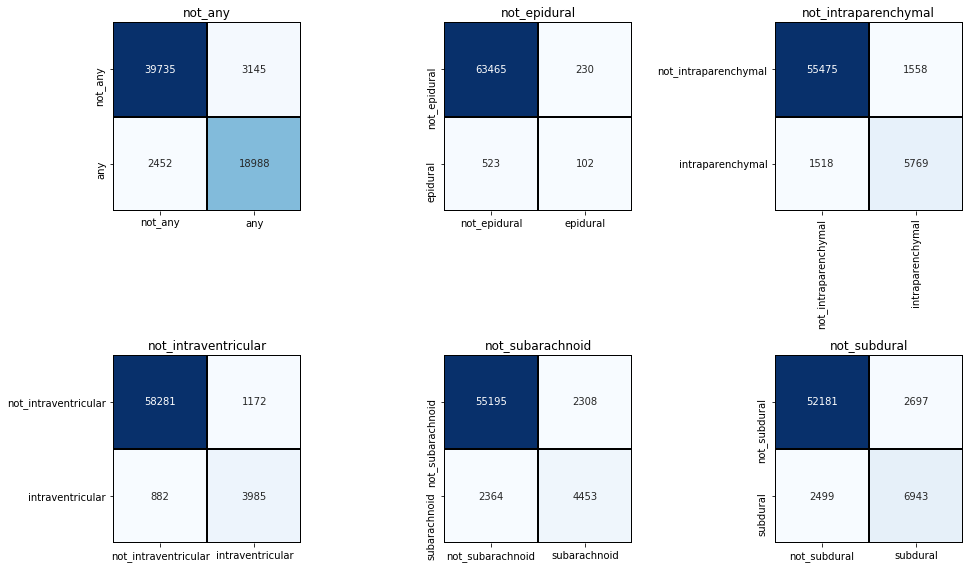

In [29]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_true, preds)
mlb= ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# AUC_ROC_SCORE

In [26]:
auc = roc_auc_score(y_true, preds)
print(auc)

0.8195484097257365


# ACCURACY and LOSS

In [27]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["accuracy"], label="train_acc")
        plt.plot(H.epoch,H.history["val_accuracy"], label="val_acc")
        plt.plot(H.epoch,H.history["loss"], label="train_loss")
        plt.plot(H.epoch,H.history["val_loss"], label="val_loss")
        plt.title("Training Accuracy and Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy/Loss")
        plt.legend(loc="lower left")
        plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


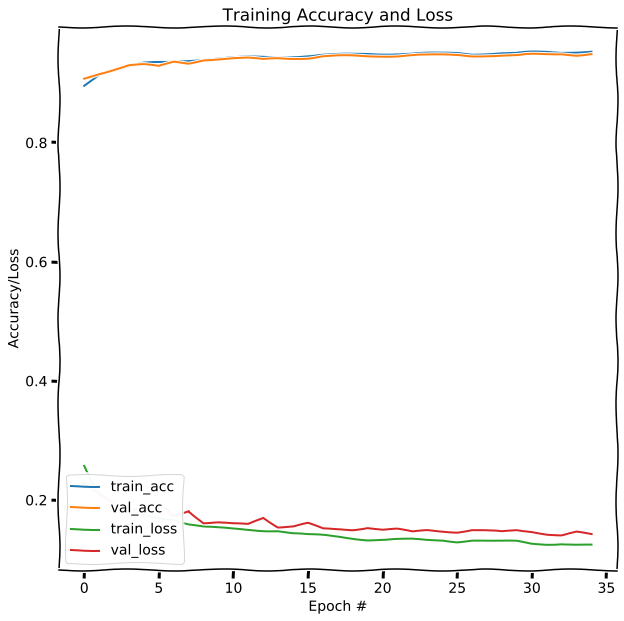

In [28]:
plot_training(history)

In [ ]:
from sklearn.utils import class_weight

#list_classes = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
#y = l[list_classes].values
#sample_weights = class_weight.compute_sample_weight('balanced', y)

In [ ]:
#sample_weights.shape

In [39]:
size =5

In [32]:
layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense').output)


In [33]:
train_prediction = intermediate_layer_model.predict_generator(train_under_generator)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [38]:
valid_prediction = intermediate_layer_model.predict_generator(valid_under_generator)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [40]:
from sklearn.externals import joblib
joblib.dump(train_prediction, 'train_Classifier1.pkl')#save model
joblib.dump(valid_prediction, 'Valid_Classifier1.pkl')#save model

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['Valid_Classifier1.pkl']

In [42]:
train_prediction.shape, valid_prediction.shape

((257598, 256), (64320, 256))

In [43]:
type(train_prediction), type(valid_prediction)

(numpy.ndarray, numpy.ndarray)

In [ ]:
from joblib import dump, load
train_prediction = load('train_Classifier1.pkl')
valid_prediction = load('Valid_Classifier1.pkl')

In [44]:
X_train_XG_SVC = train_prediction
X_dev_XG_SVC= valid_prediction

In [45]:
X_train_XG_SVC.shape

(257598, 256)

In [ ]:
y_train = l[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].values

In [48]:
import xgboost as xgb
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
seed = 42


In [ ]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True, verbose=True,class_weight={0:1.0,1:2.0}, decision_function_shape='ovr'), n_jobs=-1)
classifier.fit(X_train_XG_SVC, y_train).score(X_dev_XG_SVC, y_dev)

In [ ]:
size = 5

## SVM

In [ ]:
classifier = BinaryRelevance(svm.SVC(kernel='rbf', probability=True, verbose=True,class_weight={0:1.0,1:2.0}, decision_function_shape='ovr'))
classifier.fit(X_train_XG_SVC, y_train).score(X_dev_XG_SVC, y_dev)

In [ ]:
prediction1 = classifier.predict_proba(X_dev_XG_SVC)

In [ ]:
preds1 = np.where(prediction1 < 0.5, 0, 1)

In [ ]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds1, target_names=target_names))

In [ ]:
joblib.dump(xgb1, 'Classifier1.pkl')#save model

## Xgboost

In [ ]:
xgb1 = xgb.sklearn.XGBClassifier(
        learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=11,
         gamma=0.1,
         subsample=0.8,
         colsample_bytree=0.7,
         objective='multi:softprob',
         n_jobs=-1,
         scale_pos_weight=1,
         seed=seed)




In [ ]:
xgb1.fit(X_train_XG_SVC, y_train).score(X_dev_XG_SVC, y_dev)

In [ ]:
y_pred_xgb = xgb1.predict_proba(X_val_XG_SVC)



In [ ]:
preds2 = np.where(y_pred_xgb < 0.5, 0, 1) 

In [ ]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds2, target_names=target_names))

In [ ]:
joblib.dump(xgb1, 'Classifier2.pkl')#save model

## Stacked model

In [ ]:
final_prediction = (preds + preds1 + preds2) / 3


In [ ]:
y_train = l[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].values

In [ ]:
final_prediction = np.where(final_prediction < 0.5, 0, 1) 

In [ ]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, final_prediction, target_names=target_names))

In [ ]:
joblib.dump(final_prediction, 'final_Classifier.pkl')#save model